<a href="https://colab.research.google.com/github/jimbobfurly/electrodynamics-James-Kobelenz/blob/master/Copy_of_Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm Project
By James Kobelenz


#Acknowlegdements
The majority of the code from this project was adapted from Jupyter Notebook 8: [08-magnetic-fields.ipynb](https://github.com/dr-kinder/electrodynamics/blob/master/week-04/08-magnetic-fields.ipynb).

#Problem
Ferromagnetic objects like iron link together under the influence of magnetic field. A wire passing through an iron ring also induces a magnetic field about the ring. If we were to align multiple rings next the ring with the induced field, how many rings are noticeably influenced by the first ring’s induced magnetic field (Note: current is traveling out of screen)?

#Model
I plan to use Jupyter Notebook 8 as a starting point for this project as we have already generated and looked at magnetic fields of wires inside and outside iron rings. I plan to use a rectangular mesh for the background domain as in Notebook 7 to allow space for additional rings, but I wonder if this will mess up the Finite Element Method computation used in Notebook 8 as Notebook 8 uses a circular background domain.

#Computation
To find and plot the vector potential and magnetic field, I will solve a Poisson equation with FEniCSx as we have done before in other notebooks. From the looks of the notebook and the FEniCSx tutorial, it seems that it uses cartesian coordinates to solve the equation.

#Analysis
In a physical experiment, assuming the first and final ring of the system are fixed in place, . Theory suggests that if the current from the wire is coming out of the screen, then from the right-hand rule the magnetic field will move counterclockwise around the ring. I predict that the overall magnetic field of the system will flow in one counterclockwise direction.


# Install and Load Packages

Install FEniCSx, Gmsh, and **multiphenicsx**.

In [209]:
try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [210]:
try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [211]:
try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

In [212]:
# Import functions

import dolfinx.fem
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import multiphenicsx.fem
import multiphenicsx.io

In [531]:
## Adjust this cell to change the geometry:
# Specify sizes of the objects
# and adjust material properties.

## Rings
# Number of extra rings.
N_rings = 5

# Offset center of the extra rings  
rings_center = 2.5
main_offset = 2.5
extra_offset = 2.5

# Inner and outer radii of extra rings 
extra_rings_inner = 1.2
extra_rings_outer = 1.25

# Inner and outer radii of main ring 
ring_inner = 1     
ring_outer = 1.25

### Premade parameters: Simply uncomment 
### whichever set of parameters you want.
### (Uncomment highlighted code with CTRL+/)

# ## Small Thin Rings
# # Offset center of the extra rings  
# rings_center = 1.875
# main_offset = 1.875
# extra_offset = 1.25
# # Inner and outer radii of extra rings 
# extra_rings_inner = 0.6
# extra_rings_outer = 0.625
# # Inner and outer radii of main ring 
# ring_inner = 1     
# ring_outer = 1.25

# ## Small Thick Rings
# # Offset center of the extra rings  
# rings_center = 1.875
# main_offset = 1.875
# extra_offset = 1.25
# # Inner and outer radii of extra rings 
# extra_rings_inner = 0.3
# extra_rings_outer = 0.625
# # Inner and outer radii of main ring 
# ring_inner = 1     
# ring_outer = 1.25

# ## Thin Rings, Same Size
# # Offset center of the extra rings  
# rings_center = 2.5
# main_offset = 2.5
# extra_offset = 2.5
# # Inner and outer radii of extra rings 
# extra_rings_inner = 1.2
# extra_rings_outer = 1.25
# # Inner and outer radii of main ring 
# ring_inner = 1     
# ring_outer = 1.25

## Thick Rings, Same Size
# Offset center of the extra rings  
rings_center = 2.5
main_offset = 2.5
extra_offset = 2.5
# Inner and outer radii of extra rings 
extra_rings_inner = 0.75
extra_rings_outer = 1.25
# Inner and outer radii of main ring 
ring_inner = 1     
ring_outer = 1.25

# ## Large Thin Rings
# # Offset center of the extra rings  
# rings_center = 3.75
# main_offset = 3.75
# extra_offset = 5
# # Inner and outer radii of extra rings 
# extra_rings_inner = 2.4
# extra_rings_outer = 2.5
# # Inner and outer radii of main ring 
# ring_inner = 1     
# ring_outer = 1.25

# ## Large Thick Rings
# # Offset center of the extra rings  
# rings_center = 3.75
# main_offset = 3.75
# extra_offset = 5
# # Inner and outer radii of extra rings 
# extra_rings_inner = 1.25
# extra_rings_outer = 2.5
# # Inner and outer radii of main ring 
# ring_inner = 1     
# ring_outer = 1.25

## Material Permeability
# Magnetic permeability (relative) of main ring.
mu_ring = 10
# Magnetic permeability (relative) of extra rings.
mu_extra_rings = 5000


## Wires
# Radius of individual wires
r_wire = 0.1

# Location of centers of inner and outer rings of wires.
centers_inner = 0.8 

# Number of wires.
N_wires = 6

# Magnetic permeability (relative) of wires.
mu_wire = 2

# Current density in each wire.
J0 = 1

# Magnetic permeability (relative) of background medium
mu_background = 1


## General Parameters
# Length is dependent on number of rings
length = 5*(extra_offset+N_rings)
width = 6
L = length
W = width

# Using 2D Gmsh.
dim = 2

# Grid size parameter.  Make it smaller for higher resolution.
delta = 0.1

In [532]:
# Create a model.
gmsh.initialize()
gmsh.model.add("mesh")

# Define the system: a large rectangle .
background = gmsh.model.occ.addRectangle(-L/4, -W/2, 0, L, W)
gmsh.model.occ.synchronize()

# Define geometry for main ring.
outer_ring = gmsh.model.occ.addCircle(0, 0, 0, ring_outer)
inner_ring = gmsh.model.occ.addCircle(0, 0, 0, ring_inner)
gmsh.model.occ.addCurveLoop([outer_ring], 5)
gmsh.model.occ.addCurveLoop([inner_ring], 6)
ring = gmsh.model.occ.addPlaneSurface([5, 6])
gmsh.model.occ.synchronize()

# Starting tags for extra rings
ring_out_tag = 7
ring_in_tag = 8
extra_rings = []


# Generate n amount of rings
for n in range(N_rings):
  outer_ring1 = gmsh.model.occ.addCircle(rings_center, 0, 0, extra_rings_outer)
  inner_ring1 = gmsh.model.occ.addCircle(rings_center, 0, 0, extra_rings_inner)
  rings_center += extra_offset
  gmsh.model.occ.addCurveLoop([outer_ring1], ring_out_tag)
  gmsh.model.occ.addCurveLoop([inner_ring1], ring_in_tag)
  extra_rings.append(gmsh.model.occ.addPlaneSurface([ring_out_tag, ring_in_tag]))
  ring_out_tag += 2
  ring_in_tag += 2
  gmsh.model.occ.synchronize()

# Put extra rings into list formatted for the boundaries
rings = [(2, n) for n in extra_rings]

# Create list of circular disks to represent the wires.
# Define the wires inside the ring.
angles_in = [n * 2*np.pi/N_wires for n in range(N_wires)]
wires_in = [(2,
            gmsh.model.occ.addDisk(centers_inner * np.cos(v),
            centers_inner * np.sin(v), 0, r_wire, r_wire))
            for v in angles_in]

# Update the model.
gmsh.model.occ.synchronize()

# Resolve the boundaries of the wires and ring in the background domain.
all_surfaces = [(2, ring)]
all_surfaces.extend(rings)
all_surfaces.extend(wires_in)
whole_domain = gmsh.model.occ.fragment([(2, background)], all_surfaces)

# Update the model.
gmsh.model.occ.synchronize()

# Create physical markers for each object.
# Use the following markers:
# - Vacuum: 0
# - Ring: 1
# - Extra Rings: [2,3,...,N_rings+1]
# - Inner wires: [2+_rings,3+Extra_rings,...,N_wires+N_rings+1]
extra_rings_tag = 2
inner_tag = 2 + N_rings
background_surfaces = []
other_surfaces = []


# Gmsh can compute the mass of objects and the location of their
# centers of mass. This loop uses these properties to determine
# which object to associate grid points with.

# We will use these tags to define material properties later.
rings_center = main_offset
for domain in whole_domain[0]:
    center = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
    mass = gmsh.model.occ.getMass(domain[0], domain[1])
    

    # Identify the ring by its mass.
    # Check for ring first, because center of mass is same as background.
    if np.isclose(mass, np.pi*(ring_outer**2 - ring_inner**2)) and np.allclose(center, [0, 0, 0]):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
        other_surfaces.append(domain)

    elif np.isclose(mass, np.pi*(extra_rings_outer**2 - extra_rings_inner**2)) and np.allclose(center, [rings_center, 0, 0]):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], extra_rings_tag)
        other_surfaces.append(domain)
        extra_rings_tag += 1
        rings_center += extra_offset

    # Identify the inner wires by their centers of mass.
    elif np.isclose(np.linalg.norm(center), centers_inner):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], inner_tag)
        inner_tag += 1
        other_surfaces.append(domain)

    # Identify the background rectangle by its center of mass
    else:# np.allclose(center, [0, 0, 0]):
        background_surfaces.append(domain[1])

# Add marker for the vacuum.
gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)


# Create mesh resolution that is fine around the wires and
# make the grid coarse further away from the ring.
gmsh.model.mesh.field.add("Distance", 1)
edges = gmsh.model.getBoundary(other_surfaces, oriented=False)
gmsh.model.mesh.field.setNumbers(1, "EdgesList", [e[1] for e in edges])
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "IField", 1)
gmsh.model.mesh.field.setNumber(2, "LcMin", r_wire) # Default r_wire / 2
gmsh.model.mesh.field.setNumber(2, "LcMax", 10 * r_wire) # Default 5 * r_wire
gmsh.model.mesh.field.setNumber(2, "DistMin", 5 * r_wire) # Default 2 * r_wire
gmsh.model.mesh.field.setNumber(2, "DistMax", 10 * r_wire) # Default 4 * r_wire
gmsh.model.mesh.field.setAsBackgroundMesh(2)
gmsh.option.setNumber("Mesh.Algorithm", 7)

# Create a mesh for this system.
gmsh.model.mesh.generate(dim)

# Bring the mesh into FEniCSx.
mesh, subdomains, boundaries = dolfinx.io.gmshio.model_to_mesh(
    gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=2)

gmsh.finalize()

In [533]:
# Plot the entire mesh.
multiphenicsx.io.plot_mesh(mesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [534]:
# Plot the subdomains that FEniCSx has identified.
# There should only be one for this model.
multiphenicsx.io.plot_mesh_tags(subdomains)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [535]:
# This loop will assign material properties to each cell in our model.
# In this case, it is the relative magnetic permeability and current density.

# Define a simple function space for properties.
Q = dolfinx.fem.FunctionSpace(mesh, ("DG", 0))

# Get the list of materials.
material_tags = np.unique(subdomains.values)
print(material_tags)
# Define functions for current density and magnetic permeability.
mu = dolfinx.fem.Function(Q)
J = dolfinx.fem.Function(Q)

# Only some regions carry current. Initialize all current densities to zero.
J.x.array[:] = 0.0

# Now, cycle over all objects and assign material properties. 
for tag in material_tags:
    cells = subdomains.find(tag)
    
    # Set values for magnetic permeability.
    if tag == 0:
        # Vacuum
        mu_ = mu_background
    elif tag == 1:
        # Ring
        mu_ = mu_ring
    elif tag >= 2 and tag < (2+N_rings):
        # Extra rings 
        mu_ = mu_extra_rings
    else:
        # Wire
        mu_ = mu_wire

    mu.x.array[cells] = np.full_like(cells, mu_, dtype=petsc4py.PETSc.ScalarType)
    print(mu_)
    # Set nonzero current densities.
    if tag in range(2+N_rings, 2+N_rings+N_wires):
        J.x.array[cells] = np.full_like(cells, J0, dtype=petsc4py.PETSc.ScalarType)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
1
10
5000
5000
5000
5000
5000
2
2
2
2
2
2


In [536]:
## Set up the finite element problem.

# Define trial and test functions.
V = dolfinx.fem.FunctionSpace(mesh, ("Lagrange", 2))

# Define the trial and test functions.
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Create a function to store the solution.
# This is the vector potential.  A_x = A_y = 0.
A_z = dolfinx.fem.Function(V)

# Identify the domain and boundary.
D = mesh.topology.dim
Omega = dolfinx.mesh.locate_entities_boundary(mesh, D-1, lambda x: np.full(x.shape[1], True))
dOmega = dolfinx.fem.locate_dofs_topological(V, D-1, Omega)

# Force the potential to vanish on the boundary.
bc = dolfinx.fem.dirichletbc(petsc4py.PETSc.ScalarType(0), dOmega, V)

# Define the Poisson equation we are trying to solve.
a = (1 / mu) * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = 4 * ufl.pi * J * v * ufl.dx

# Define the problem.
problem = dolfinx.fem.petsc.LinearProblem(a, L, u=A_z, bcs=[bc])

# Solve the problem.
problem.solve()

Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, equispaced, unset, False), 2), 78), Basix element (P, triangle, 2, gll_warped, unset, False)), 179)

In [537]:
# Compute the magnetic field.
W = dolfinx.fem.VectorFunctionSpace(mesh, ("CG", 2))
B = dolfinx.fem.Function(W)
B_expr = dolfinx.fem.Expression(ufl.as_vector((A_z.dx(1), -A_z.dx(0))), W.element.interpolation_points())
B.interpolate(B_expr)

#Results
It seems that and infinite number of rings can be added without any loss of the magnetic field. This simulation not take other real life factors into account (e.g. gravity, air permeability, friction). In a physical experiment, there would be a limit to how many rings would be attracted to the original ring with wires runinng through it. For instance, if gravity was considered, the limit of rings would occur when the gravitational pull exceeds the magnetic attraction. 

For large quantities of rings, the mesh had to be made very course in order for colab to processes and plot the magnetic field without crashing. 

In [538]:
# Plot the vector potential.
multiphenicsx.io.plot_scalar_field(A_z,"Vector Potential", warp_factor=1)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [539]:
# Plot the magnetic field.
multiphenicsx.io.plot_vector_field(B,"Magnetic Field", glyph_factor=0.2)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

#Small Thin Rings

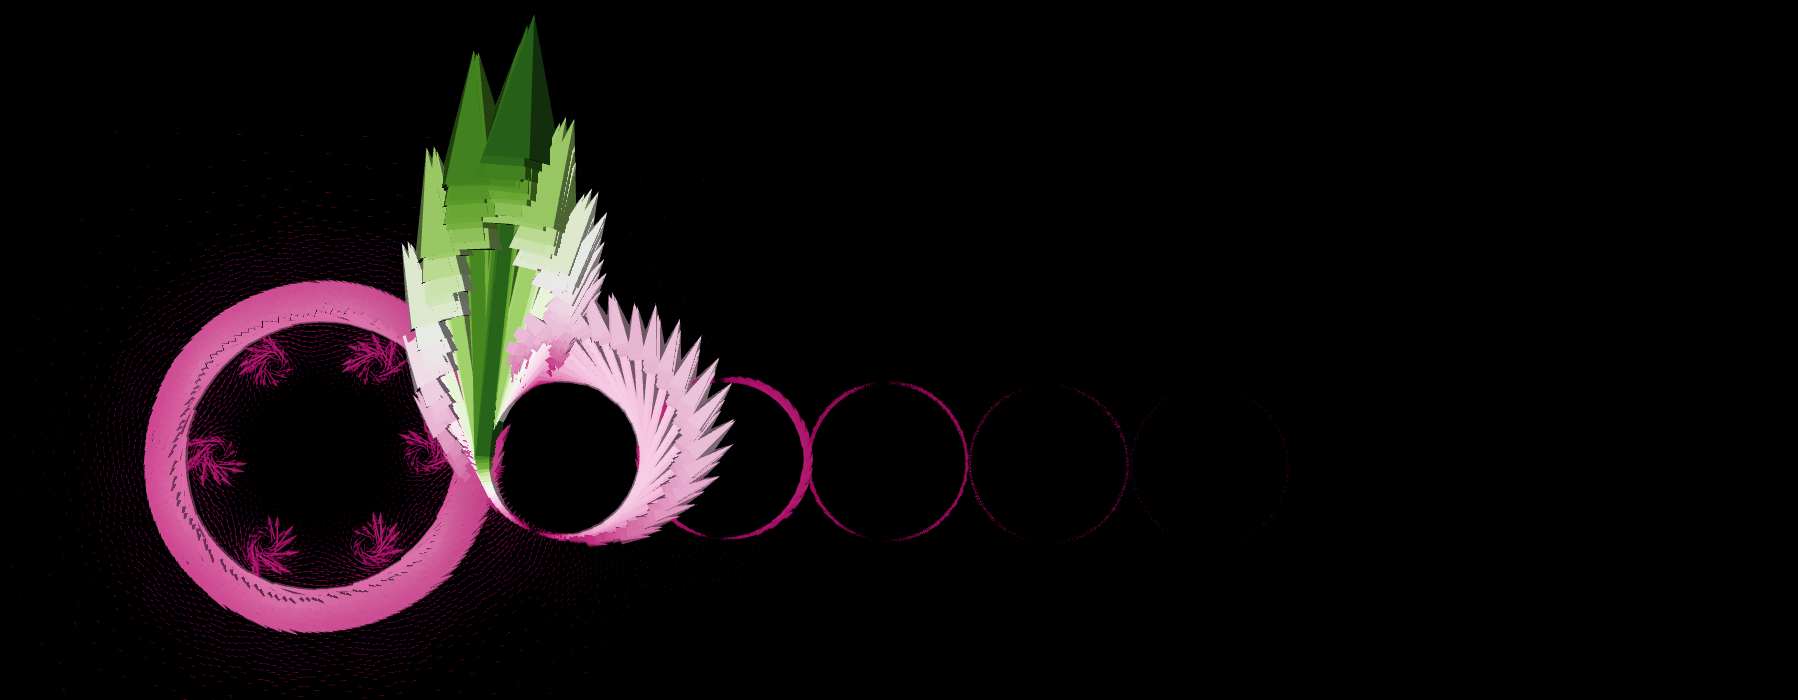

#Small Thick Rings

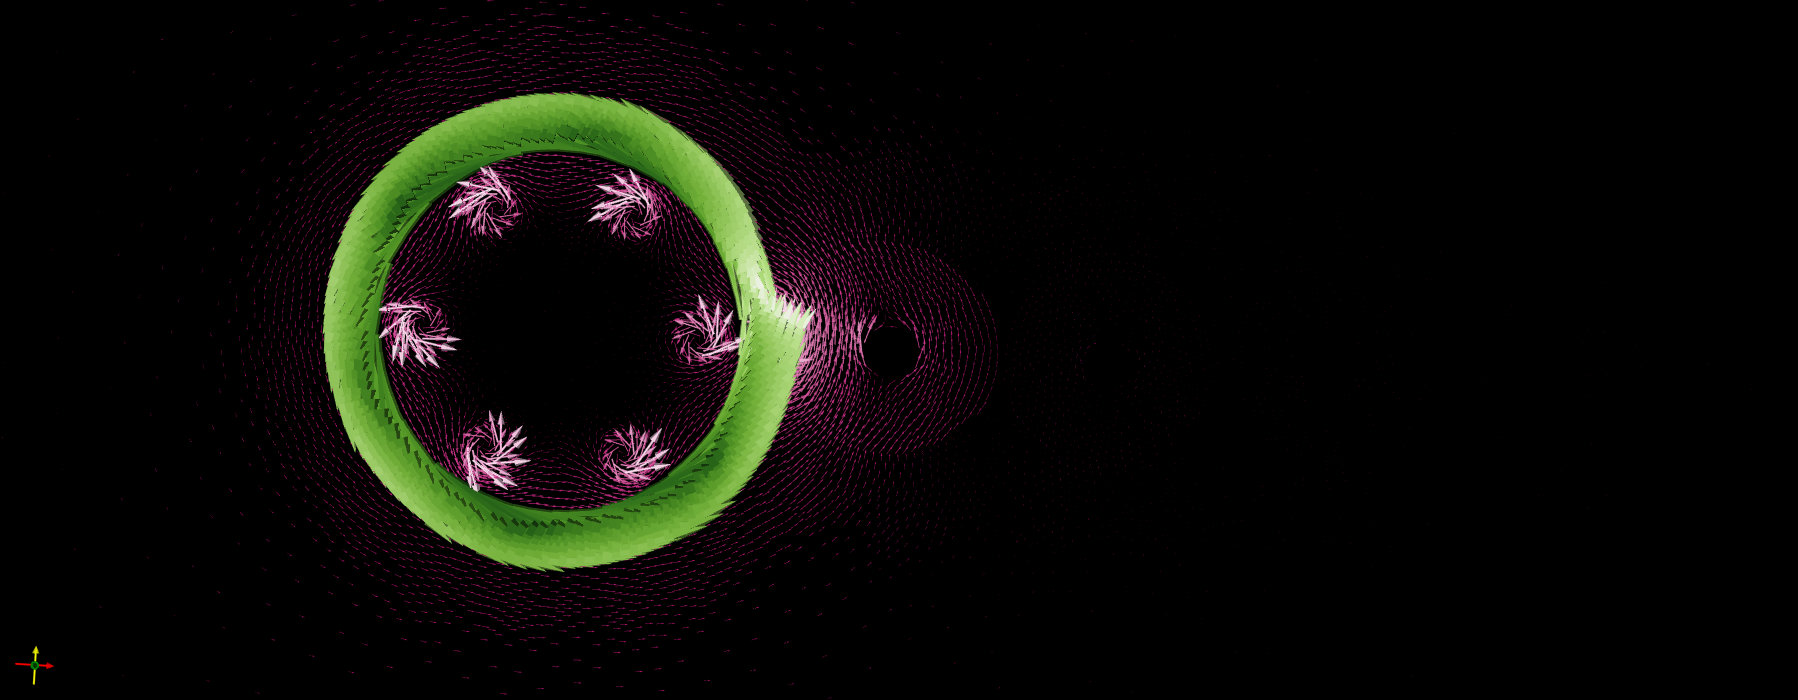

#Thin Rings, Same Size

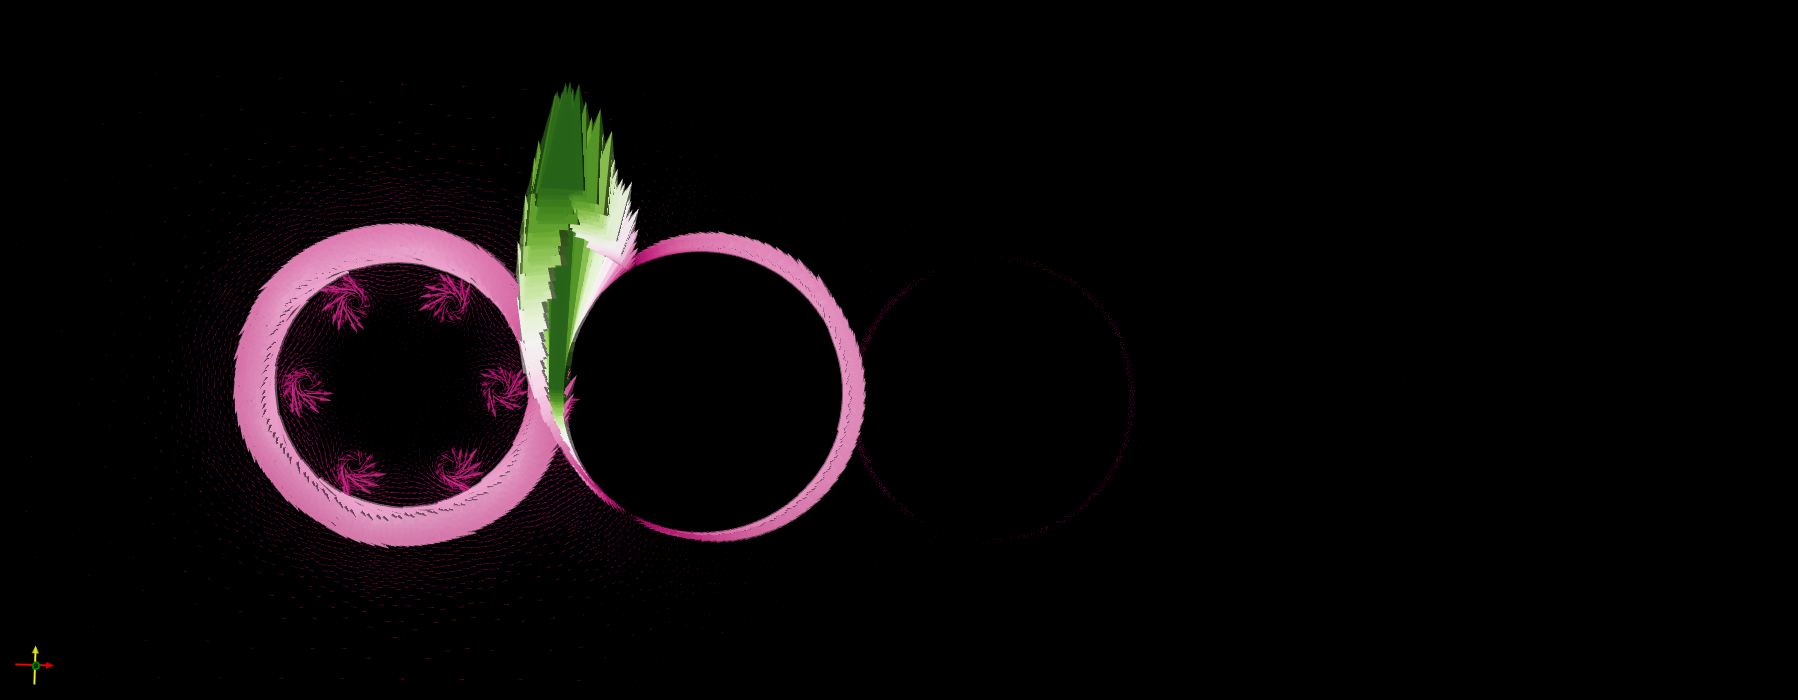

#Thick Rings, Same Size

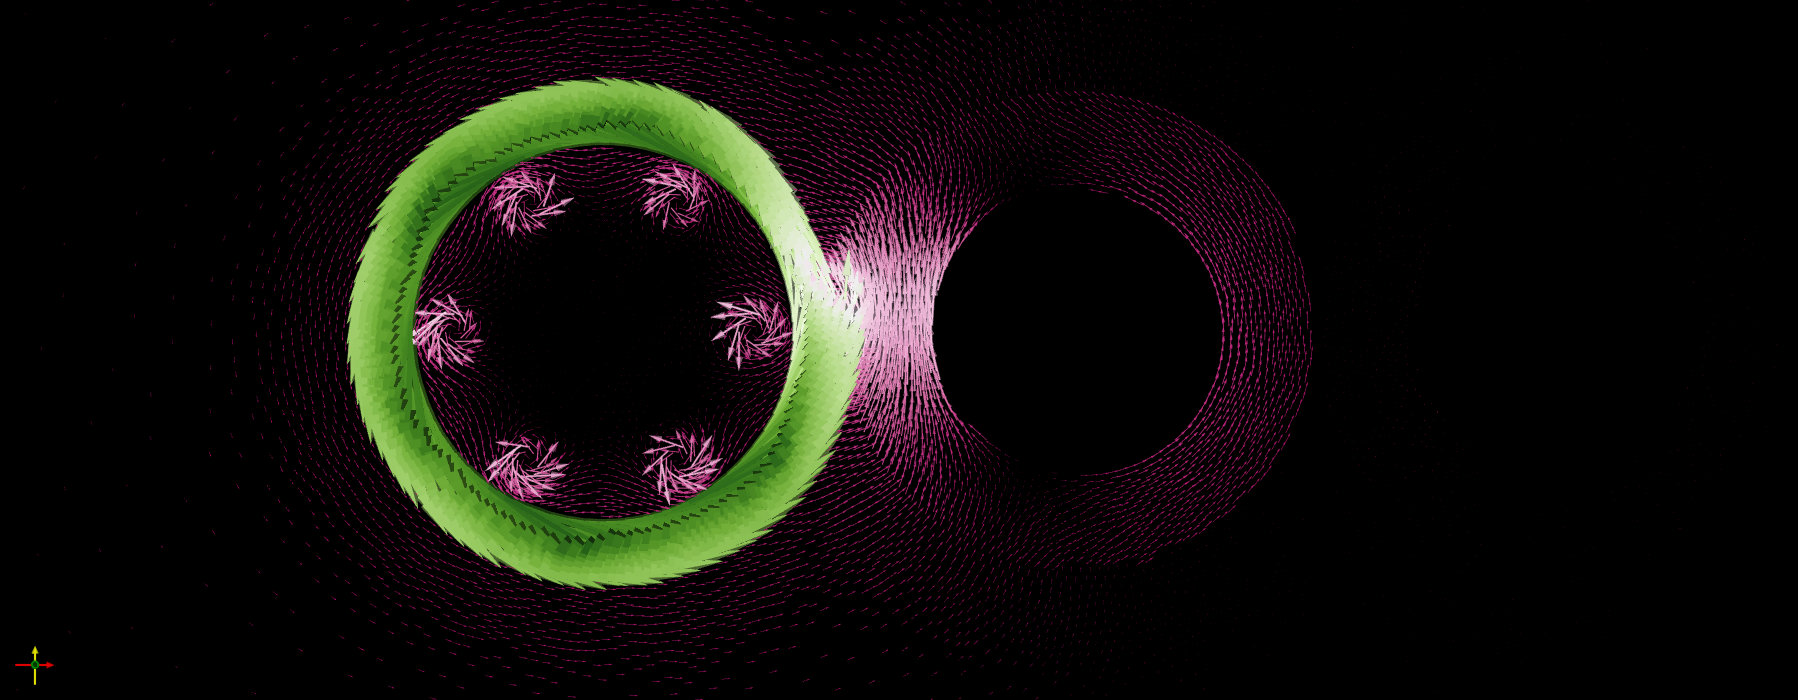

#Large Thin Rings

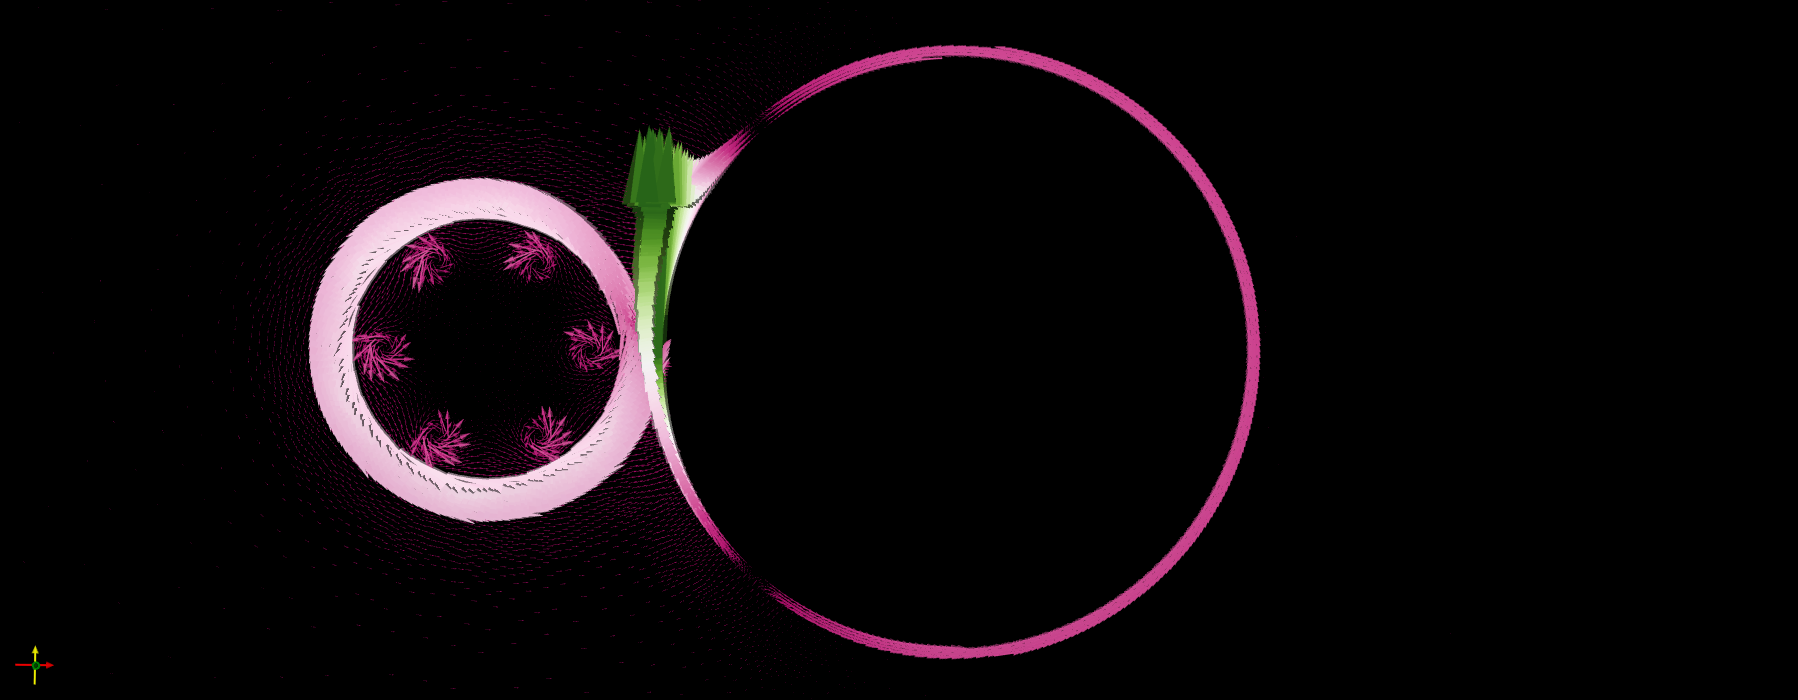

#Large Thick Rings

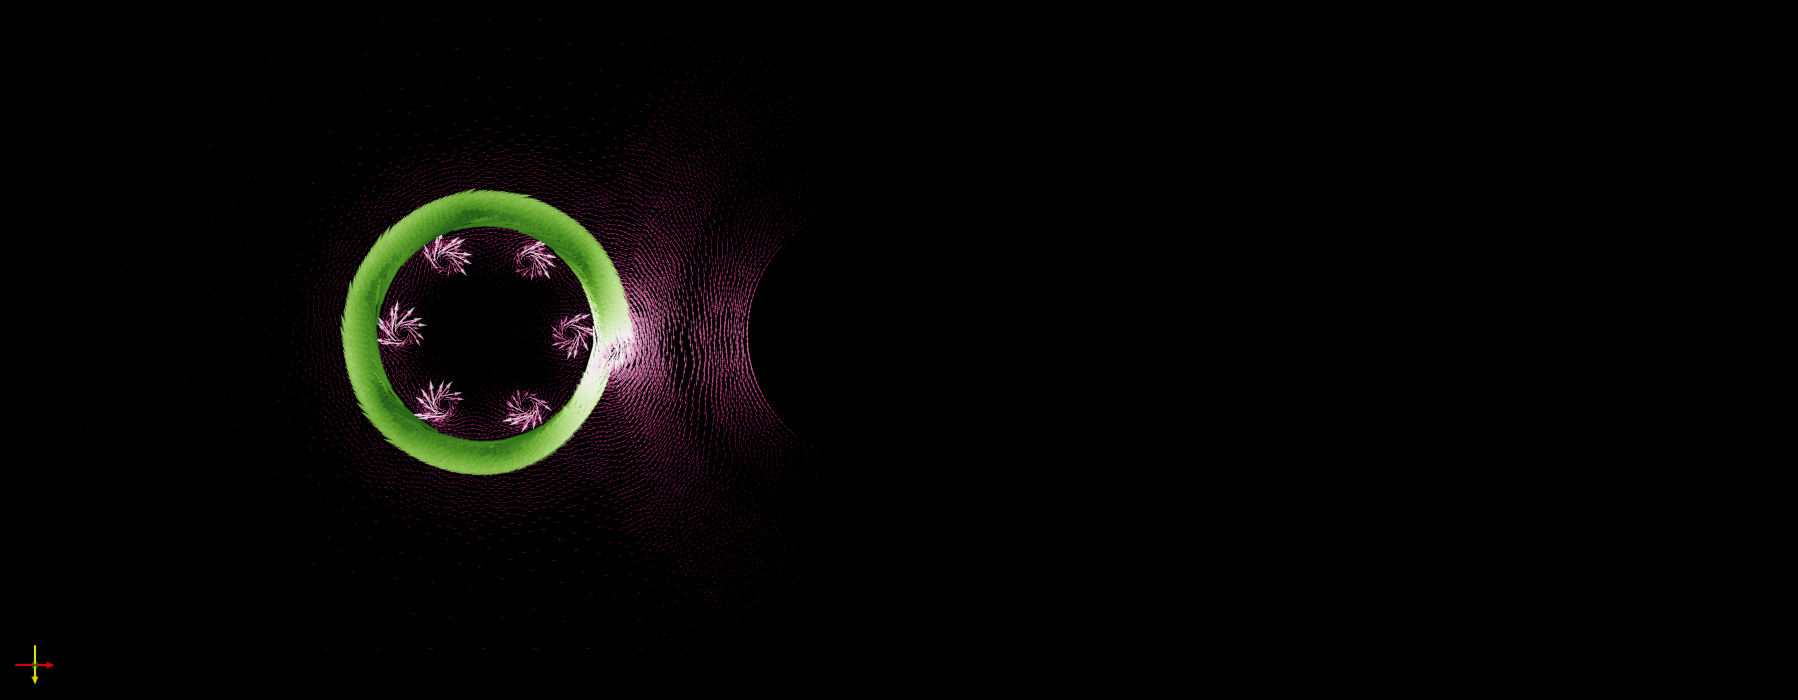